In [18]:
import sys
sys.path.insert(0, '..')
from lineage import graphs, similarity

In [19]:
import pandas as pd
import os
import networkx as nx

In [20]:
#RESULT_DIR = '/home/suhail/ok/'
RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/'
#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_50k/'
#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_100_10000/'
#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat/'

#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/nopivot/'
#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_ppo/'
#RESULT_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected/'

In [21]:
notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]


In [22]:
len(notebooks)

200

In [23]:
from collections import defaultdict
import glob


def get_notebook_artifact_list(nb):
    artifact_dir = RESULT_DIR+nb+'/artifacts/'
    return [os.path.basename(x) for x in glob.glob(artifact_dir+'*.csv')]


def generate_artifact_dict(notebooks):
    notebook_dict = defaultdict(list)
    for nb in notebooks:
        artifacts = frozenset(get_notebook_artifact_list(nb))
        notebook_dict[artifacts].append(nb)
        
    return notebook_dict
        
        
def find_duplicates(artifact_dict):
    return dict(filter(lambda x: len(x[1]) > 1 , artifact_dict.items()))
    

def dedup_notebooks(notebooks):
    artifact_dict = generate_artifact_dict(notebooks)
    final_list = []
    for afs,nbs in artifact_dict.items():
        final_list.append(nbs[0])
        
    return final_list

In [24]:
d_notebooks = dedup_notebooks(notebooks)


In [25]:
from collections import Counter


def get_wrong_edges(exp_graph):
    f_counter = Counter()
    for edge_t in exp_graph.edges(data=True):
        if 'correct' not in exp_graph[edge_t[0]][edge_t[1]]:
            if 'truth' in exp_graph[edge_t[0]][edge_t[1]] and exp_graph[edge_t[0]][edge_t[1]]['truth'] == True:
                if 'operation' in exp_graph[edge_t[0]][edge_t[1]]:
                    f_counter[exp_graph[edge_t[0]][edge_t[1]]['operation']] += 1
                else:
                    f_counter['unknown'] += 1

    return f_counter

In [26]:
from collections import Counter

def get_notebook_result(result_dir, nb, filename='relic_agglomerative_result.csv'):
    return pd.read_csv(result_dir+'/'+nb+'/'+filename, index_col=0)

errors = []
int_columns = ['artifacts', 'columns', 'rows']

def experiment1_results():
    result = pd.DataFrame()
    fcounter = Counter()
    for nb in d_notebooks:
        try:
            nb_result = get_notebook_result(RESULT_DIR,nb).iloc[-1]
            baseline_result = get_notebook_result(RESULT_DIR,nb,filename='baseline_union_result.csv').iloc[-1]
            g = graphs.get_graph(RESULT_DIR,nb)
            artifacts = get_notebook_artifact_list(nb)
            diff = set(g.nodes()).symmetric_difference(set(artifacts))
            print(diff)
            nb_result['files'] = len(artifacts)
            nb_result['symdiff'] = len(diff)
            nb_result['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            baseline_result['files'] = len(artifacts)
            baseline_result['symdiff'] = len(diff)
            baseline_result['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            result = result.append(nb_result)
            result = result.append(baseline_result)
            # find the operations that are worst offenders
            g_truth = graphs.get_graph(RESULT_DIR, nb)
            g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, 'cell')
            dist = graphs.get_distance_matrix(RESULT_DIR, nb, 'cell')
            exp_graph = graphs.generate_explaination_graph(g_truth, g_infered, dist)
            fcounter += get_wrong_edges(exp_graph)
        except FileNotFoundError as e:
            errors.append(nb)
            #print(e)
            pass
    return result.astype({x:'int64' for x in int_columns})



def experiment2_results():
    result = pd.DataFrame()
    for nb in notebooks:
        try:
            
            result = result.append(get_notebook_result(RESULT_DIR,nb, filename='relic_thresholding_final_result.csv'))

        except FileNotFoundError as e:
            errors.append(nb)
            raise
    return result.astype({x:'int64' for x in int_columns})


def experiment3_results():
    result = pd.DataFrame()
    
    metrics = ['cell', 'col', 'valset', 'ivalset', 'colvalset', 'cellvalset']
    
    for nb in notebooks:
        try:
            for metric in metrics:
                result = result.append(get_notebook_result(RESULT_DIR,nb, filename='relic_thresholding_final_result_'+metric+'.csv'), ignore_index=True)

        except FileNotFoundError as e:
            errors.append(nb)
            raise
    return result.astype({x:'int64' for x in int_columns})

In [27]:
from collections import Counter
import pickle

def get_notebook_result(result_dir, nb, filename='relic_agglomerative_result.csv'):
    return pd.read_csv(result_dir+'/'+nb+'/'+filename, index_col=0)

errors = []
int_columns = ['artifacts', 'columns', 'rows']

def experiment1_results():
    result = pd.DataFrame()
    fcounter = Counter()
    for nb in notebooks:
        try:
            #cell_result = get_notebook_result(RESULT_DIR,nb, filename='cell_relic_result.csv').iloc[-1]
            #col_result = get_notebook_result(RESULT_DIR,nb,filename='col_relic_result.csv').iloc[-1]
            #pc2_cellcol_result = get_notebook_result(RESULT_DIR,nb,filename='pc2cellcol_relic_result.csv').iloc[-1]
            #pc2_colcell_result = get_notebook_result(RESULT_DIR,nb,filename='pc2colcell_relic_result.csv').iloc[-1]
            #valset_result = get_notebook_result(RESULT_DIR,nb,filename='valset_relic_result.csv').iloc[-1]
            #rowvalset_result = get_notebook_result(RESULT_DIR,nb,filename='rowvalset_relic_result.csv').iloc[-1]
            #colvalset_result = get_notebook_result(RESULT_DIR,nb,filename='colvalset_relic_result.csv').iloc[-1]
            #cellvalset_result = get_notebook_result(RESULT_DIR,nb,filename='cellvalset_relic_result.csv').iloc[-1]
            #cell_result = get_notebook_result(RESULT_DIR,nb, filename='cell_relic_result.csv').iloc[-1]
            #cellgroup_result = get_notebook_result(RESULT_DIR,nb, filename='cell+group_relic_result.csv').iloc[-1]
            #celljoin_result = get_notebook_result(RESULT_DIR,nb, filename='cell+join_relic_result.csv').iloc[-1]
            #cellgroupjoin_result = get_notebook_result(RESULT_DIR,nb, filename='cell+group+join_relic_result.csv').iloc[-1]
            
            result_files = [os.path.basename(x) for x in glob.glob(RESULT_DIR+'/'+nb+'/*_relic_result.csv')]
            result_list = []
            
            for f in result_files:
                r = get_notebook_result(RESULT_DIR,nb, filename=f).iloc[-1]
                try:
                    new_f1 = compute_new_PR_from_result(RESULT_DIR, nb, r['distance_metric'])
                    r['Updated P'] = new_f1['Precision']
                    r['Updated R'] = new_f1['Recall']
                    r['Updated F1'] = new_f1['F1']
                except:
                    raise
                    pass
                result_list.append(r)
                

            g = graphs.get_graph(RESULT_DIR,nb)
            artifacts = get_notebook_artifact_list(nb)
            diff = set(g.nodes()).symmetric_difference(set(artifacts))
            
            combined = pd.DataFrame()
            combined = combined.append(result_list)
            combined['files'] = len(artifacts)
            combined['symdiff'] = len(diff)
            combined['gt_comp'] = len([x for x in nx.weakly_connected_components(g)])
            isdag = nx.is_directed_acyclic_graph(g)
            combined['isdag'] = isdag
            if isdag:
                combined['pathlen'] = nx.dag_longest_path_length(g)
                
                
            result = result.append(combined)
            
            

            # find the operations that are worst offenders
            g_truth = graphs.get_graph(RESULT_DIR, nb)
            g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, 'cell')
            dist = graphs.get_distance_matrix(RESULT_DIR, nb, 'cell')
            exp_graph = graphs.generate_explaination_graph(g_truth, g_infered, dist)
            fcounter += get_wrong_edges(exp_graph)
            
            
            
        
        except FileNotFoundError as e:
            errors.append(nb)
            print(e)
            pass
    
    return result

In [28]:
result = experiment1_results()
#result = result.replace('pc2cellcoltimestamp+group+pivot', 'pc2cellcoltimestamp+group+join+pivot')
len(set(result.nb_name.values))

col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge group
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge grou

Edge found in equiv edge group
col
Edge found in equiv edge group
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+

col
cell+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
cell
Edge found in equiv edge group
Edge found in equiv edge group
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge group
cell+group+join+pivot
Edge fo

198

In [26]:
result.loc[result['Updated F1'] > result['F1']]

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,pre_cluster,stage_name,Updated P,Updated R,Updated F1,files,symdiff,gt_comp,isdag,pathlen
5,20201005-231321,100,20,22,False,11,cell+group+join+pivot,19,2,1,...,No Precluster,5_pivot,0.950000,0.904762,0.926829,22,0,1,True,6
0,20201005-225833,50000,10,21,False,7,col,12,8,8,...,No Precluster,1_flat,0.650000,0.650000,0.650000,21,0,1,True,5
8,20201005-225833,50000,10,21,False,7,pc2cellcolj1+group+join+pivot,17,3,3,...,PC2,3_inter,0.900000,0.900000,0.900000,21,0,1,True,5
0,20201005-225833,50000,10,21,False,7,cell,17,3,3,...,No Precluster,1_flat,0.900000,0.900000,0.900000,21,0,1,True,5
0,20201006-062036,50000,20,58,False,38,cell,39,18,18,...,No Precluster,1_flat,0.701754,0.701754,0.701754,58,0,1,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,20201006-060359,10000,20,53,False,13,cell+group+join+pivot,40,12,11,...,No Precluster,5_pivot,0.803922,0.788462,0.796117,53,0,1,True,9
24,20201006-060359,10000,20,53,False,13,pc2cell+group+join+pivot,40,12,11,...,PC2,5_pivot,0.803922,0.788462,0.796117,53,0,1,True,9
60,20201006-060359,10000,20,53,False,13,pc2cellcolj1+group+join+pivot,41,11,11,...,PC2,4_group,0.807692,0.807692,0.807692,53,0,1,True,9
0,20201006-060359,10000,20,53,False,13,cell,38,14,14,...,No Precluster,1_flat,0.750000,0.750000,0.750000,53,0,1,True,9


In [57]:
import shutil

# Clean up of Workflows with missing ground truth
for nb in errors:
    try:
        g_truth = graphs.get_graph(RESULT_DIR, nb)
    except FileNotFoundError as e:
        full_path = RESULT_DIR+nb
        print("Removing", full_path)
        #shutil.rmtree(full_path)

Removing /home/suhail/Projects/relic/primitives/python/generator/dataset_flat_50k/20201001-193219


In [66]:
result

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,Updated P,Updated R,Updated F1,files,symdiff,gt_comp,isdag,pathlen,artifacts2,artifacts3
0,20201005-232052,50000,20,24,False,14,col,21,2,2,...,0.913043,0.913043,0.913043,24,0,1,True,6,<30,"<30,50000,20"
6,20201005-232052,50000,20,24,False,14,cell+group+join+pivot,22,1,1,...,0.956522,0.956522,0.956522,24,0,1,True,6,<30,"<30,50000,20"
15,20201005-232052,50000,20,24,False,14,pc2cell+group+join+pivot,22,1,1,...,0.956522,0.956522,0.956522,24,0,1,True,6,<30,"<30,50000,20"
28,20201005-232052,50000,20,24,False,14,pc2cellcolj1+group+join+pivot,20,3,3,...,0.869565,0.869565,0.869565,24,0,1,True,6,<30,"<30,50000,20"
0,20201005-232052,50000,20,24,False,14,cell,18,5,5,...,0.782609,0.782609,0.782609,24,0,1,True,6,<30,"<30,50000,20"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20201005-225849,50000,10,20,False,3,col,18,1,1,...,0.947368,0.947368,0.947368,20,0,1,True,6,<30,"<30,50000,10"
2,20201005-225849,50000,10,20,False,3,cell+group+join+pivot,18,1,1,...,0.947368,0.947368,0.947368,20,0,1,True,6,<30,"<30,50000,10"
5,20201005-225849,50000,10,20,False,3,pc2cell+group+join+pivot,17,2,2,...,0.894737,0.894737,0.894737,20,0,1,True,6,<30,"<30,50000,10"
22,20201005-225849,50000,10,20,False,3,pc2cellcolj1+group+join+pivot,17,2,2,...,0.894737,0.894737,0.894737,20,0,1,True,6,<30,"<30,50000,10"


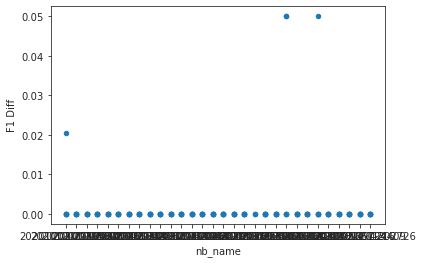

In [59]:
result['F1 Diff'] = result['Updated F1'] - result['F1']
result.plot.scatter(y='F1 Diff', x='nb_name')

In [60]:
result

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,pre_cluster,Updated P,Updated R,Updated F1,files,symdiff,gt_comp,isdag,pathlen,F1 Diff
0,20201001-195945,50000.0,10.0,50.0,False,27.0,col,36.0,13.0,13.0,...,No Precluster,0.755102,0.755102,0.755102,50,0,1,True,13,2.040816e-02
11,20201001-195945,50000.0,10.0,50.0,False,27.0,cell+group+join+pivot,42.0,7.0,7.0,...,No Precluster,0.857143,0.857143,0.857143,50,0,1,True,13,0.000000e+00
34,20201001-195945,50000.0,10.0,50.0,False,27.0,pc2cell+group+join+pivot,42.0,7.0,7.0,...,PC2,0.857143,0.857143,0.857143,50,0,1,True,13,0.000000e+00
59,20201001-195945,50000.0,10.0,50.0,False,27.0,pc2cellcolj1+group+join+pivot,42.0,7.0,7.0,...,PC2,0.857143,0.857143,0.857143,50,0,1,True,13,0.000000e+00
0,20201001-195945,50000.0,10.0,50.0,False,27.0,cell,39.0,10.0,10.0,...,No Precluster,0.795918,0.795918,0.795918,50,0,1,True,13,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20201001-202726,50000.0,20.0,52.0,False,29.0,col,38.0,13.0,13.0,...,No Precluster,0.745098,0.745098,0.745098,52,0,1,True,10,0.000000e+00
12,20201001-202726,50000.0,20.0,52.0,False,29.0,cell+group+join+pivot,46.0,5.0,4.0,...,No Precluster,0.920000,0.901961,0.910891,52,0,1,True,10,1.110223e-16
35,20201001-202726,50000.0,20.0,52.0,False,29.0,pc2cell+group+join+pivot,45.0,6.0,5.0,...,PC2,0.900000,0.882353,0.891089,52,0,1,True,10,0.000000e+00
63,20201001-202726,50000.0,20.0,52.0,False,29.0,pc2cellcolj1+group+join+pivot,44.0,7.0,6.0,...,PC2,0.880000,0.862745,0.871287,52,0,1,True,10,0.000000e+00


In [72]:
result.time.max()

20635.999219533

In [62]:
sample_baseline = result.groupby('distance_metric').mean()

In [63]:
result = experiment1_results()


col
Edge found in equiv edge group
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+piv

In [46]:
result.groupby('rows').count()

,files,symdiff,gt_comp,isdag,pathlen,nb_name,columns,artifacts,index,numclusters,...,join_edges,precision,recall,F1,missing_files,time,pre_cluster,Updated P,Updated R,Updated F1
rows,,,,,,,,,,,,,,,,,,,,,
50000.0,147,147,147,147,147,147,147,147,147,147,...,0,147,147,147,147,147,147,147,147,147
100000.0,83,83,83,83,83,83,83,83,83,83,...,0,83,83,83,83,83,83,83,83,83


In [14]:
result_sample = ['20201005-225548',
'20201005-225553',
'20201005-225557',
'20201005-225601',
'20201005-225606',
'20201005-225611',
'20201005-225613',
'20201005-225617',
'20201005-225621',
'20201005-225626',
'20201005-225631',
'20201005-225635',
'20201005-225643',
'20201005-225647',
'20201005-225654',
'20201005-225657',
'20201005-225701',
'20201005-225706',
'20201005-225712',
'20201005-225717',
'20201005-225722',
'20201005-225729',
'20201005-225736',
'20201005-225745',
'20201005-225750',
'20201005-225756',
'20201005-225800',
'20201005-225806',
'20201005-225818',
'20201005-225827',
'20201005-225833',
'20201005-225849',
'20201005-225904',
'20201005-225931',
'20201005-230029',
'20201005-230209',
'20201005-230229',
'20201005-230300',
'20201005-230336',
'20201005-230401',
'20201005-230419',
'20201005-230526',
'20201005-230628',
'20201005-230651',
'20201005-230748',
'20201005-230814',
'20201005-230906',
'20201005-230925',
'20201005-230939',
'20201005-231028',
'20201005-231243',
'20201005-231249',
'20201005-231255',
'20201005-231258',
'20201005-231303',
'20201005-231310',
'20201005-231312',
'20201005-231317',
'20201005-231321',
'20201005-231328',
'20201005-231335',
'20201005-231338',
'20201005-231343',
'20201005-231349',
'20201005-231357',
'20201005-231407',
'20201005-231415',
'20201005-231422',
'20201005-231432',
'20201005-231435',
'20201005-231442',
'20201005-231500',
'20201005-231515',
'20201005-231521',
'20201005-231531',
'20201005-231545',
'20201005-231553',
'20201005-231614',
'20201005-231623',
'20201005-231631',
'20201005-231642',
'20201005-231806',
'20201005-231907',
'20201005-231939',
'20201005-232052',
'20201005-232157',
'20201005-232320',
'20201005-232343',
'20201005-232443',
'20201005-232620',
'20201005-232701',
'20201006-043814',
'20201006-043926',
'20201006-044026',
'20201006-044339',
'20201006-044520',
'20201006-044708',
'20201006-045052',
'20201006-045143',
'20201006-045326',
'20201006-045439',
'20201006-045502',
'20201006-045538',
'20201006-045556',
'20201006-045612',
'20201006-045630',
'20201006-045710',
'20201006-045731',
'20201006-045753',
'20201006-045811',
'20201006-045833',
'20201006-045901',
'20201006-045933',
'20201006-045956',
'20201006-050018',
'20201006-050032',
'20201006-050104',
'20201006-050210',
'20201006-050228',
'20201006-050245',
'20201006-050322',
'20201006-050347',
'20201006-050409',
'20201006-050453',
'20201006-050513',
'20201006-050535',
'20201006-050557',
'20201006-050617',
'20201006-050647',
'20201006-050710',
'20201006-050817',
'20201006-050857',
'20201006-050956',
'20201006-051116',
'20201006-051226',
'20201006-051505',
'20201006-051606',
'20201006-051726',
'20201006-051906',
'20201006-052023',
'20201006-052156',
'20201006-052436',
'20201006-052650',
'20201006-052746',
'20201006-053031',
'20201006-053516',
'20201006-053612',
'20201006-053727',
]

col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge group
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge grou

col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge group
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
Edge found in equiv edge group
cell+group+join+pivot
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
cell
Edge found in equiv edge group
col
Edge found in equiv edge group
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+

cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
pc2cell+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
pc2cellcolj1+group+join+pivot
Edge found in equiv edge group
Edge found in equiv edge group
cell
Edge found in equiv edge group
Edge found in equiv edge group
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+group+join+pivot
cell
col
cell+group+join+pivot
pc2cell+group+join+pivot
pc2cellcolj1+grou

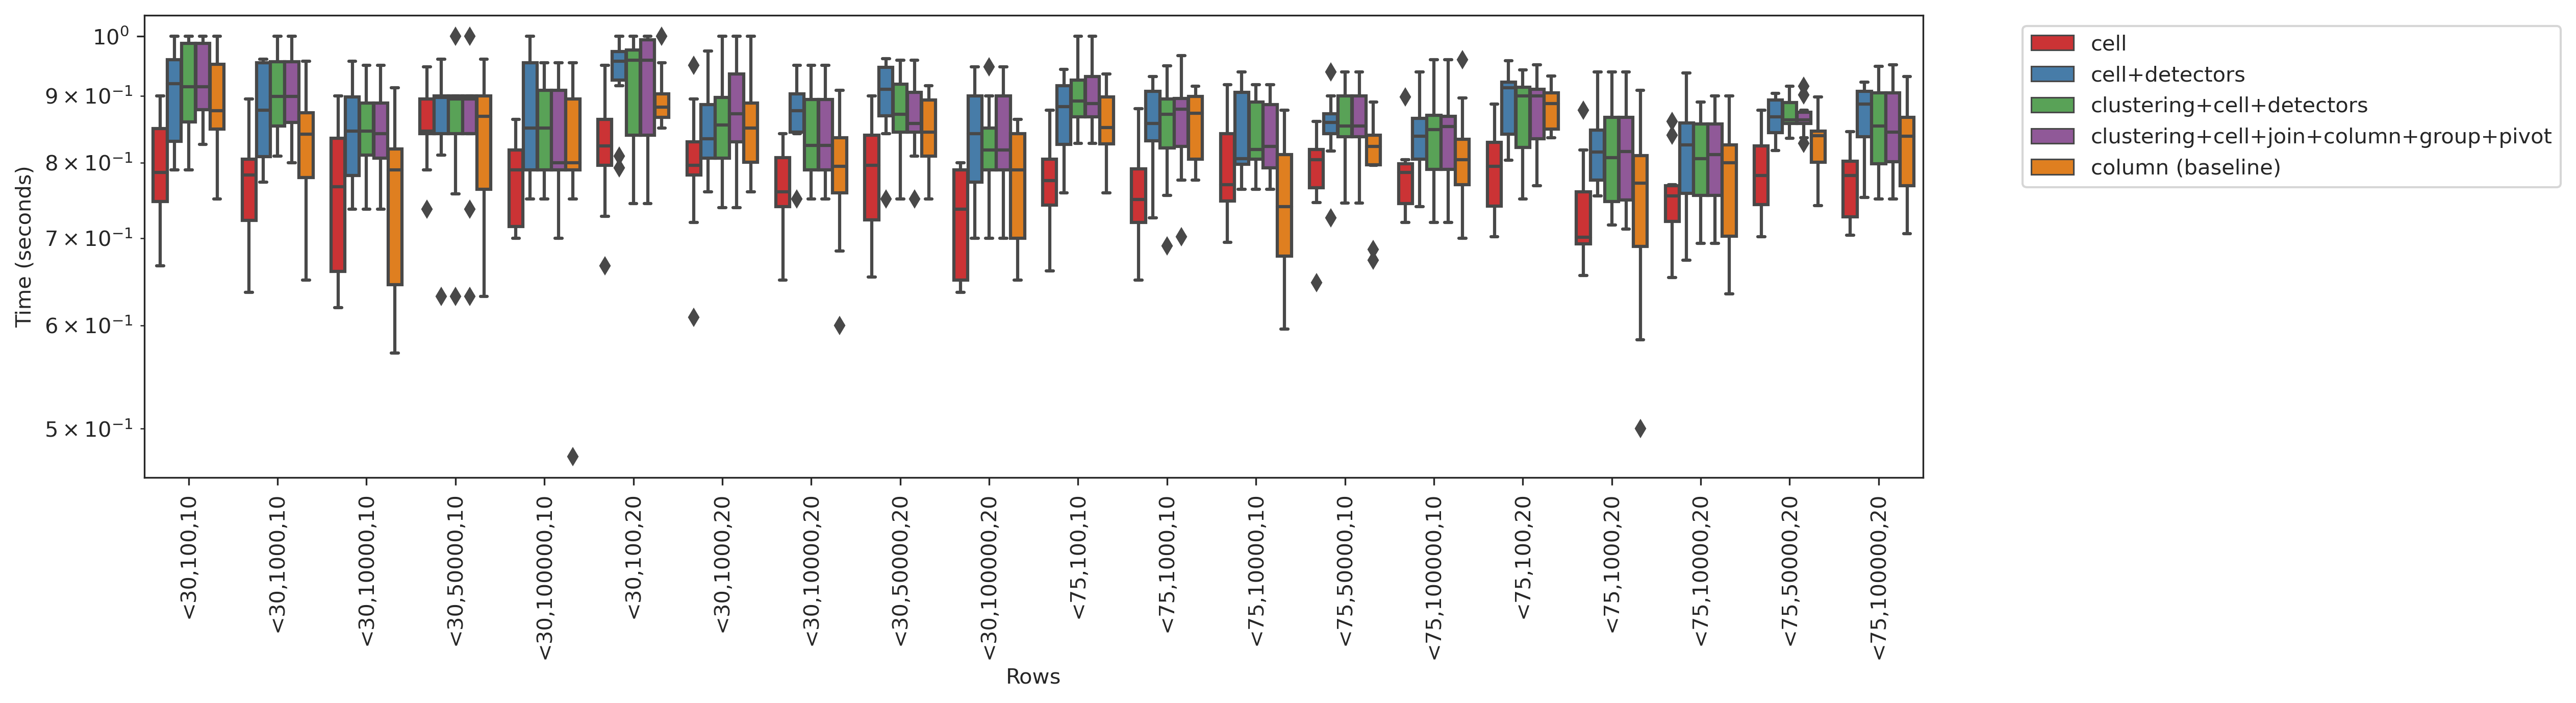

In [29]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(num=None, figsize=(15, 4), dpi=300, facecolor='w', edgecolor='k')

result = experiment1_results()
#result = result.replace('pc2cellcoltimestamp+group+pivot', 'pc2cellcoltimestamp+group+join+pivot')
#sns.set()
sns.set_style("ticks")


#sns.set_style("darkgrid", {"axes.facecolor": ".9"})



#order = list(set(result.distance_metric.values))

order = ['cell', 'cell+group+join+pivot', 
         'pc2cell+group+join+pivot', 'pc2cellcolj1+group+join+pivot','col']

'''
order = ['cell', 'cell+group+join+transform+pivot', 
         'pc2cell+group+join+transform+pivot', 'pc2cellcolj1+group+join+tranform+pivot','col']
'''
#order = ['pc2cellgt+group+join+pivot']



# Grouped boxplot


#result = result.loc[result.nb_name.isin(result_sample)]
result['artifacts2'] = result['artifacts'].apply(lambda x: '<30' if x < 30 else '<75')
result['artifacts3'] = result["artifacts2"].astype(str) +','+ result["rows"].astype(str) + ',' +result["columns"].astype(str)

#sample_baselines = result
#sample_baselines = result.set_index(['artifacts3','rows','columns']).sort_index()
sample_baselines = result.set_index(['nb_name']).sort_index()
chart = sns.boxplot(x=sample_baselines.artifacts3, y='Updated F1', hue="distance_metric", data=sample_baselines, 
                    palette="Set1", hue_order=order)

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#chart.get_xaxis().set_visible(False)
#chart.xaxis.grid(True) 
#plt.legend(loc='best')
L = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

L.get_texts()[0].set_text('cell')
L.get_texts()[1].set_text('cell+detectors')
#L.get_texts()[2].set_text('clustering+cell+column')
#L.get_texts()[2].set_text('clustering+cell+column+detectors')
L.get_texts()[2].set_text('clustering+cell+detectors')
L.get_texts()[3].set_text('clustering+cell+join+column+group+pivot')
L.get_texts()[4].set_text('column (baseline)')
#L.get_texts()[5].set_text('column (baseline) + gt_tie_breaker')



plt.xlabel('Rows')
plt.ylabel('Time (seconds)')

chart.set_yscale('log')

#plt.ylim(0.35,1.0)


In [30]:
#test = sample_baselines[['distance_metric','Updated F1']].index
#test
#chart = sns.boxplot(x=test.index, y="Updated F1", hue="distance_metric", data=test, palette="Set1", hue_order=order)
sample_baselines

,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,...,Updated P,Updated R,Updated F1,files,symdiff,gt_comp,isdag,pathlen,artifacts2,artifacts3
nb_name,,,,,,,,,,,,,,,,,,,,,
20201005-225548,100,10,27,False,18,cell,23,3,3,NaN,...,0.884615,0.884615,0.884615,27,0,1,True,5,<30,"<30,100,10"
20201005-225548,100,10,27,False,18,pc2cellcolj1+group+join+pivot,21,5,5,NaN,...,0.807692,0.807692,0.807692,27,0,1,True,5,<30,"<30,100,10"
20201005-225548,100,10,27,False,18,pc2cell+group+join+pivot,21,5,5,NaN,...,0.807692,0.807692,0.807692,27,0,1,True,5,<30,"<30,100,10"
20201005-225548,100,10,27,False,18,cell+group+join+pivot,26,0,0,NaN,...,1.000000,1.000000,1.000000,27,0,1,True,5,<30,"<30,100,10"
20201005-225548,100,10,27,False,18,col,26,0,0,NaN,...,1.000000,1.000000,1.000000,27,0,1,True,5,<30,"<30,100,10"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201006-070956,100000,20,58,False,31,cell+group+join+pivot,49,8,7,NaN,...,0.875000,0.859649,0.867257,58,0,1,True,8,<75,"<75,100000,20"
20201006-070956,100000,20,58,False,31,pc2cell+group+join+pivot,37,20,20,NaN,...,0.649123,0.649123,0.649123,58,0,1,True,8,<75,"<75,100000,20"
20201006-070956,100000,20,58,False,31,pc2cellcolj1+group+join+pivot,37,20,20,NaN,...,0.649123,0.649123,0.649123,58,0,1,True,8,<75,"<75,100000,20"


In [73]:
sample_baselines = result.set_index(['nb_name']).sort_index()
pivoted = sample_baselines.pivot(columns='distance_metric', values='Updated F1')
pivoted

distance_metric,cell,cell+group+join+pivot,col,pc2cell+group+join+pivot,pc2cell+group+join+transform+pivot,pc2cellcolj1+group+join+pivot
nb_name,,,,,,
20201005-225548,0.884615,1.000000,1.000000,0.807692,NaN,0.807692
20201005-225553,0.900000,0.900000,0.950000,0.900000,NaN,0.950000
20201005-225557,0.695652,0.888889,0.869565,0.826087,NaN,0.826087
20201005-225601,0.789474,0.789474,0.842105,0.789474,NaN,0.842105
20201005-225606,0.826087,0.956522,0.956522,0.782609,NaN,0.782609
...,...,...,...,...,...,...
20201006-065037,0.771930,0.831858,0.859649,0.831858,NaN,0.824561
20201006-065605,0.807692,0.884615,0.846154,0.865385,NaN,0.846154
20201006-065854,0.779661,0.871795,0.830508,0.717949,NaN,0.779661


In [61]:
pivoted.loc[(pivoted['pc2cellcolj1+group+join+pivot'] < pivoted['col'])].index#.to_excel('colbetter.xlsx')#.index

Index(['20201005-225548', '20201005-225553', '20201005-225557',
       '20201005-225606', '20201005-225611', '20201005-225621',
       '20201005-225626', '20201005-225635', '20201005-225654',
       '20201005-225712', '20201005-225717', '20201005-225806',
       '20201005-225818', '20201005-225849', '20201005-230029',
       '20201005-230526', '20201005-230628', '20201005-230814',
       '20201005-231028', '20201005-231243', '20201005-231249',
       '20201005-231258', '20201005-231312', '20201005-231317',
       '20201005-231338', '20201005-231343', '20201005-231349',
       '20201005-231407', '20201005-231415', '20201005-231432',
       '20201005-231442', '20201005-231521', '20201005-231531',
       '20201005-231553', '20201005-231642', '20201005-231806',
       '20201005-232157', '20201005-232443', '20201005-232620',
       '20201006-044026', '20201006-045439', '20201006-045502',
       '20201006-045538', '20201006-045556', '20201006-045630',
       '20201006-045710', '20201006-0457

In [76]:
pivoted['diff'] = pivoted['cell+group+join+pivot'] - pivoted['col']
pivoted.sort_values('diff').loc[pivoted['diff'] < 0].index

Index(['20201005-230628', '20201005-231422', '20201006-053727',
       '20201005-231243', '20201005-225806', '20201005-231357',
       '20201006-050817', '20201006-050104', '20201005-231312',
       '20201005-231415', '20201005-225601', '20201006-050032',
       '20201006-061227', '20201005-225553', '20201005-231435',
       '20201006-054505', '20201006-054651', '20201006-045556',
       '20201006-045933', '20201006-055217', '20201006-054523',
       '20201006-065037', '20201006-070956', '20201005-225613',
       '20201006-045612', '20201006-045731', '20201006-045901',
       '20201005-231432', '20201005-231328', '20201005-232443',
       '20201006-052156', '20201006-055330', '20201006-053031',
       '20201006-061450', '20201006-054444', '20201006-051726',
       '20201006-045753', '20201006-054412', '20201006-064624',
       '20201006-054802'],
      dtype='object', name='nb_name')

In [62]:
# Print full paths

nbs = ['20201005-225548', '20201005-225553', '20201005-225557',
       '20201005-225606', '20201005-225611', '20201005-225621',
       '20201005-225626', '20201005-225635', '20201005-225654',
       '20201005-225712', '20201005-225717', '20201005-225806',
       '20201005-225818', '20201005-225849', '20201005-230029',
       '20201005-230526', '20201005-230628', '20201005-230814',
       '20201005-231028', '20201005-231243', '20201005-231249',
       '20201005-231258', '20201005-231312', '20201005-231317',
       '20201005-231338', '20201005-231343', '20201005-231349',
       '20201005-231407', '20201005-231415', '20201005-231432',
       '20201005-231442', '20201005-231521', '20201005-231531',
       '20201005-231553', '20201005-231642', '20201005-231806',
       '20201005-232157', '20201005-232443', '20201005-232620',
       '20201006-044026', '20201006-045439', '20201006-045502',
       '20201006-045538', '20201006-045556', '20201006-045630',
       '20201006-045710', '20201006-045731', '20201006-045811',
       '20201006-045833', '20201006-045901', '20201006-045933',
       '20201006-045956', '20201006-050018', '20201006-050104',
       '20201006-050245', '20201006-050617', '20201006-050710',
       '20201006-050817', '20201006-051726', '20201006-052436',
       '20201006-053031', '20201006-053727', '20201006-054348',
       '20201006-054412', '20201006-054444', '20201006-054505',
       '20201006-054523', '20201006-054544', '20201006-054617',
       '20201006-054631', '20201006-054651', '20201006-054713',
       '20201006-054802', '20201006-054834', '20201006-054947',
       '20201006-055127', '20201006-055217', '20201006-055509',
       '20201006-060609', '20201006-060633', '20201006-061227',
       '20201006-061450', '20201006-062036', '20201006-063337',
       '20201006-064624', '20201006-065037', '20201006-065854',
       '20201006-070956']

for nb in nbs:
    print(RESULT_DIR+nb)


/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225548
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225553
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225557
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225606
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225611
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225621
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225626
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225635
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225654
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225712
/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_full/20201005-225717
/home/suha

In [27]:
import qgrid
qgrid_widget = qgrid.show_grid(test, show_toolbar=True)
qgrid_widget



QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

False

In [241]:
filtered_df = qgrid_widget.get_changed_df()
df1= filtered_df[['distance_metric', 'edges_correct', 'edges_missing', 'edges_to_remove', 'F1']].replace({'pc2cellcoltimestamp+group+join+transform+pivot': 'our technique',
                                                                                                'col': 'column_baseline'})
df1.to_csv('df1.csv')

,distance_metric,edges_correct,edges_missing,edges_to_remove,F1
34,pc2cellcolj1+group+join+pivot,48,4,4,0.923077
32,pc2cellcolj1+group+join+pivot,51,5,4,0.918919
13,pc2cellcolj1+group+join+pivot,20,2,2,0.909091
17,pc2cellcolj1+group+join+pivot,20,2,2,0.909091
20,pc2cellcolj1+group+join+pivot,48,4,4,0.923077
...,...,...,...,...,...
9,pc2cellcolj1+group+join+pivot,19,1,1,0.950000
31,pc2cellcolj1+group+join+pivot,49,4,4,0.924528
35,pc2cellcolj1+group+join+pivot,49,4,4,0.924528
14,pc2cellcolj1+group+join+pivot,21,1,0,0.976744


In [62]:
qgrid_widget.get_changed_df()

,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
nb_name,,,,,,,,,,,,,,,,,,,,,
20200529-101010,100,10,23,False,10,col,18,4,1,NaN,...,0.818182,0.878049,0,0.057733,No Precluster,23,0,1,True,3
20200529-101010,100,10,23,False,10,pc2cell+join+group+transform+pivot,18,4,3,NaN,...,0.818182,0.837209,0,4.790296,PC2,23,0,1,True,3
20200529-101011,1000,10,23,False,10,col,14,7,6,NaN,...,0.666667,0.682927,0,0.070902,No Precluster,23,0,2,True,4
20200529-101011,1000,10,23,False,10,pc2cell+join+group+transform+pivot,15,6,7,NaN,...,0.714286,0.697674,0,29.665936,PC2,23,0,2,True,4
20200529-101015,100,10,53,False,13,col,33,19,16,NaN,...,0.634615,0.653465,0,0.178432,No Precluster,53,0,1,True,7
20200529-101015,100,10,53,False,13,pc2cell+join+group+transform+pivot,34,18,19,NaN,...,0.653846,0.647619,0,127.994457,PC2,53,0,1,True,7
20200529-101016,1000,10,56,False,27,col,47,7,2,NaN,...,0.870370,0.912621,0,0.214899,No Precluster,56,0,2,True,12
20200529-101016,1000,10,56,False,27,pc2cell+join+group+transform+pivot,44,10,11,NaN,...,0.814815,0.807339,0,356.568355,PC2,56,0,2,True,12
20200529-101018,100,20,56,False,29,col,45,9,4,NaN,...,0.833333,0.873786,0,0.181257,No Precluster,56,0,2,True,6


In [113]:
result['distance_metric'].replace('join+group+transform+pivot','detectors')


7                          cell+group
14                       pc2cell+join
14                 pc2cell+join+group
0                                 col
8                     cell+join+group
                   ...               
5        pc2cell+join+group+transform
5                             pc2cell
2           cell+join+group+transform
2     cell+join+group+transform+pivot
0                                cell
Name: distance_metric, Length: 97, dtype: object

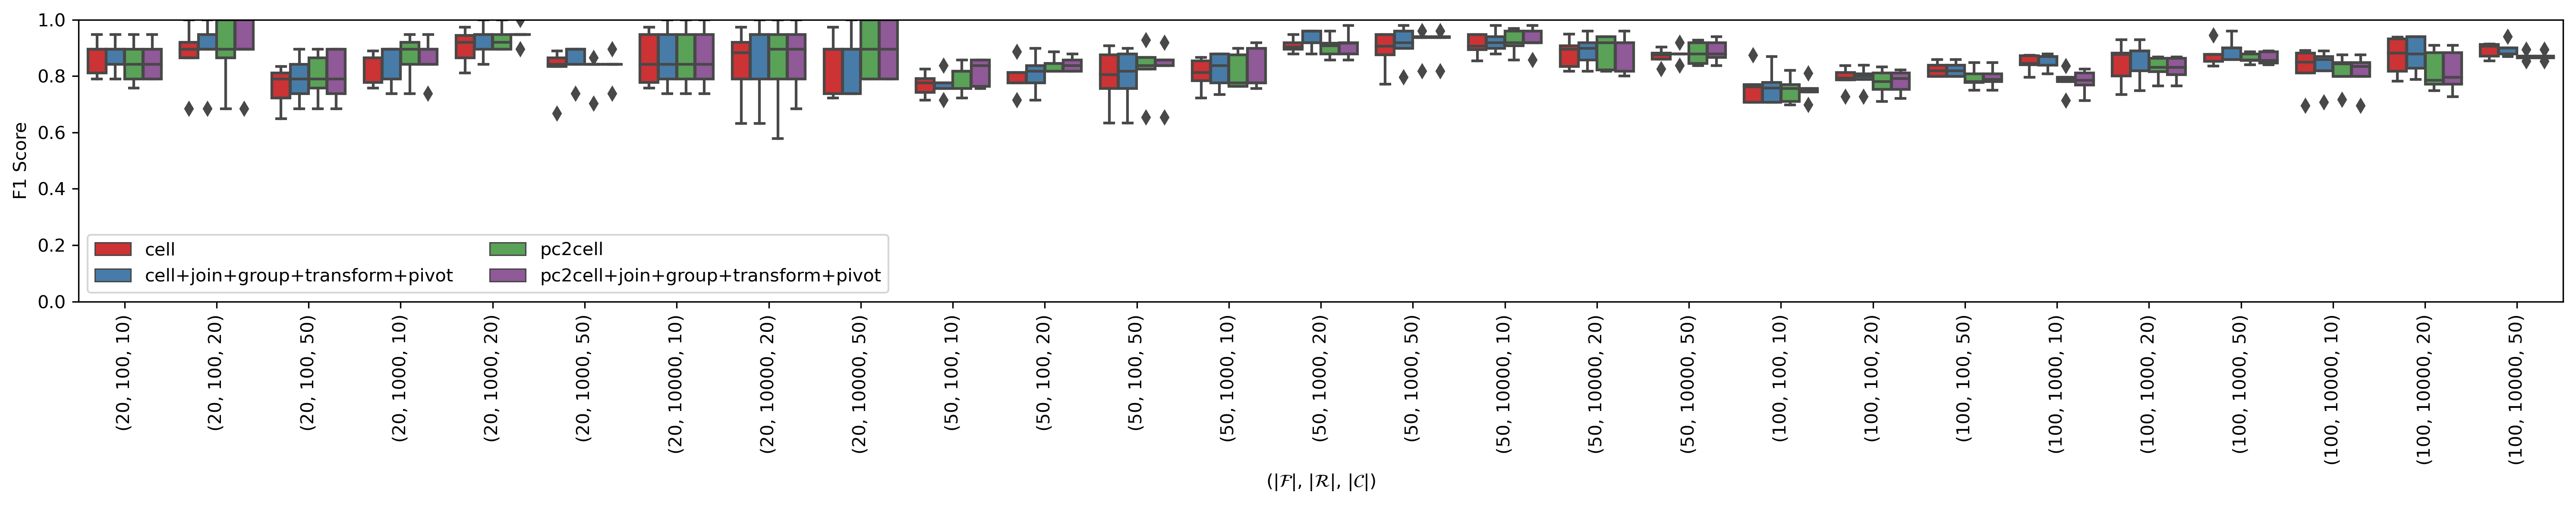

In [195]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


order = [
    'cell',
    'cell+join+group+transform+pivot',
    'pc2cell',
    'pc2cell+join+group+transform+pivot'
]

fig = plt.figure(num=None, figsize=(20, 4), dpi=300, facecolor='w', edgecolor='k')
#result = result.set_index(['artifacts','rows','columns']).sort_index()
 
# Grouped boxplot
chart = sns.boxplot(x=result.index, y="F1", hue="distance_metric", data=result, palette="Set1", hue_order=order)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.legend(loc='best',ncol=2)
plt.xlabel(r'($|\mathcal{F}|$, $|\mathcal{R}|$, $|\mathcal{C}|$)')
plt.ylabel('F1 Score')
plt.ylim(0,1.0)
plt.tight_layout()


plt.savefig('mb0_baseline_col_union.pdf')


In [196]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt

#Experiment 3
sample_baselines = result.loc[result.distance_metric.isin(['cellvalset','colvalset', 'valset', 'rowvalset'])]
#sample_baselines = result0
sample_baselines = sample_baselines.replace('ivalset', 'rowvalset')

 
# Grouped boxplot

for nb in notebooks:
    for measure in ['F1', 'precision', 'recall']:
        nb_result = sample_baselines.loc[sample_baselines.nb_name == nb]
        fig = plt.figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
        chart = sns.lineplot(x="threshold", y=measure, hue="distance_metric", data=nb_result, palette="Set1", markers=True, style="distance_metric")

        plt.legend(loc='best')
        #plt.xlabel('threshold')
        plt.title(nb+' ('+str(len(graphs.get_graph(RESULT_DIR, nb).edges()))+ ' edges)')
        plt.ylabel(measure)
        plt.ylim(0,1.0)



ValueError: Could not interpret input 'threshold'

<Figure size 800x400 with 0 Axes>

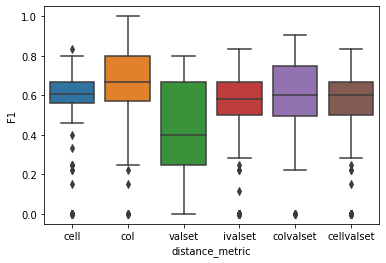

In [247]:
sns.boxplot(x='distance_metric', y='F1', data=result)

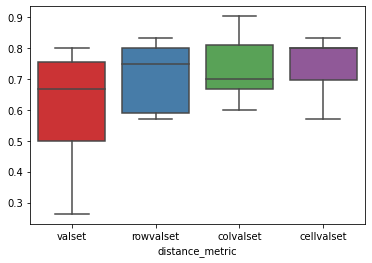

In [252]:
grouped = sample_baselines.groupby(['nb_name','distance_metric']).max()
unstacked = grouped[['F1']].unstack()
#sns.boxplot(data=unstacked)
unstacked.columns = unstacked.columns.droplevel()
sns.boxplot(data=unstacked, palette='Set1', order=['valset','rowvalset','colvalset', 'cellvalset'])

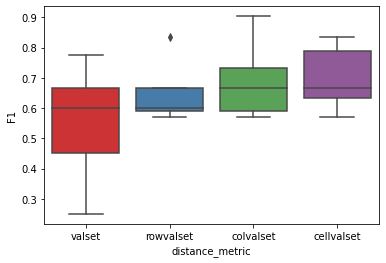

In [269]:
lowest = result.loc[result.threshold == 0]
#unstacked = grouped[['F1']].unstack()
#sns.boxplot(data=unstacked)
#unstacked.columns = unstacked.columns.droplevel()
lowest
sns.boxplot(x='distance_metric', y='F1', data=lowest, palette='Set1', order=['valset','rowvalset','colvalset', 'cellvalset'])

In [274]:
lowest

,F1,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,threshold,time
0,0.709677,16,5,cell,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.733333,0.687500,446169,0.0,43.439336
20,0.903226,16,5,col,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.933333,0.875000,446169,0.0,0.864265
40,0.774194,16,5,valset,12.0,4.0,3.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.800000,0.750000,446169,0.0,0.862285
60,0.580645,16,5,rowvalset,9.0,7.0,6.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.600000,0.562500,446169,0.0,0.854956
80,0.903226,16,5,colvalset,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.933333,0.875000,446169,0.0,0.886470
100,0.774194,16,5,cellvalset,12.0,4.0,3.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.800000,0.750000,446169,0.0,0.863440
120,0.600000,21,16,cell,12.0,8.0,8.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.600000,0.600000,17379,0.0,101.384827
140,0.750000,21,16,col,15.0,5.0,5.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.750000,0.750000,17379,0.0,0.458535
160,0.250000,21,16,valset,5.0,15.0,15.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.250000,0.250000,17379,0.0,0.462396
180,0.600000,21,16,rowvalset,12.0,8.0,8.0,0.0,NaN,0.0,retail,9.0,No Precluster,0.600000,0.600000,17379,0.0,0.450983


In [171]:
sample_baselines.loc[sample_baselines.nb_name == nb]

,F1,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,threshold,time
0,0.709677,16,5,cell,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.6875,0.733333,446169,0.00,42.759626
1,0.571429,16,5,cell,8.0,8.0,4.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,0.666667,446169,0.05,0.954413
2,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.10,0.869419
3,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.15,0.862188
4,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.20,0.827485
5,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.25,0.855924
6,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.30,0.854481
7,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.35,0.854207
8,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.40,0.833366
9,0.666667,16,5,cell,8.0,8.0,0.0,0.0,NaN,0.0,london-crime,8.0,No Precluster,0.5000,1.000000,446169,0.45,0.862440


In [416]:
result.loc[result.isdag == True].sort_values('pathlen')

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,nb_123698.ipynb,5000,9,7,False,4,cell,0,0,6,...,0.000000,0.000000,0,0.088841,No Precluster,7,6,1,True,0.0
2,nb_138215.ipynb,33,1,6,False,5,pc2colcell,0,0,2,...,0.000000,0.000000,0,0.051398,PC2,6,4,2,True,0.0
2,nb_138215.ipynb,33,1,6,False,5,pc2cellcol,0,0,2,...,0.000000,0.000000,0,0.042695,PC2,6,4,2,True,0.0
0,nb_138215.ipynb,33,1,6,False,5,col,0,0,5,...,0.000000,0.000000,0,0.016623,No Precluster,6,4,2,True,0.0
0,nb_138215.ipynb,33,1,6,False,5,cell,0,0,5,...,0.000000,0.000000,0,0.023075,No Precluster,6,4,2,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,nb_118732.ipynb,49,1,18,False,11,cell,6,6,11,...,0.352941,0.413793,0,0.250968,No Precluster,18,4,2,True,5.0
1,nb_120345.ipynb,90734,21,11,False,2,pc2cellcol,7,7,1,...,0.875000,0.636364,0,3.576903,PC2,11,0,1,True,8.0
0,nb_120345.ipynb,90734,21,11,False,2,col,6,8,1,...,0.857143,0.571429,0,3.496959,No Precluster,11,0,1,True,8.0
0,nb_120345.ipynb,90734,21,11,False,2,cell,7,7,1,...,0.875000,0.636364,0,30.856354,No Precluster,11,0,1,True,8.0


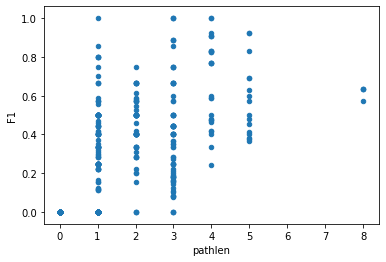

In [417]:
result.loc[result.isdag == True].plot.scatter('pathlen','F1')

Text(0, 0.5, 'F1 Score')

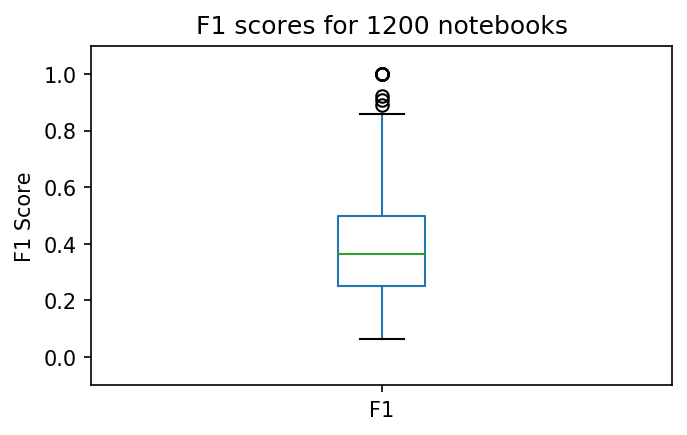

In [139]:
import matplotlib.pyplot as plt 
fig = plt.figure(num=None, figsize=(5,3), dpi=150, facecolor='w', edgecolor='k')

ax = result[result.F1 > 0 ]['F1'].plot.box('F1')
plt.ylim(-0.1,1.1)
plt.title('F1 scores for '+str(len(result.index))+' notebooks')
ax.set_ylabel('F1 Score')

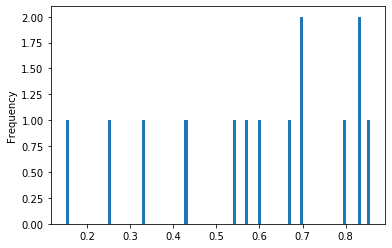

In [19]:
result['F1'].plot.hist(bins=100)

In [20]:
cleaner = result[(result.symdiff == 0) & (result.gt_comp == 1)]
cleaner

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
8,0.800000,8.0,18,5,pandas_cell,12.0,6.0,0.0,18.0,1.0,...,NaN,0.0,london-crime,8.0,PC2,0.666667,1.000000,446169,0.0,22.470568
0,0.857143,0.0,18,5,pandas_col,15.0,3.0,2.0,18.0,1.0,...,NaN,0.0,nb_331056.ipynb,8.0,No Preclustering,0.833333,0.882353,446169,0.0,5.526874
8,0.700000,8.0,21,16,pandas_cell,14.0,6.0,6.0,21.0,1.0,...,NaN,0.0,retail,9.0,PC2,0.700000,0.700000,17379,0.0,29.700569
0,0.150000,0.0,21,16,pandas_col,3.0,17.0,17.0,21.0,1.0,...,NaN,0.0,retail,9.0,No Preclustering,0.150000,0.150000,17379,0.0,9.881040
8,0.700000,8.0,13,12,pandas_cell,7.0,5.0,1.0,13.0,1.0,...,NaN,0.0,titanic,9.0,PC2,0.583333,0.875000,891,0.0,2.469796
0,0.250000,0.0,13,12,pandas_col,3.0,9.0,9.0,13.0,1.0,...,NaN,0.0,titanic,9.0,No Preclustering,0.250000,0.250000,891,0.0,0.305215
1,0.545455,1.0,8,13,pandas_cell,3.0,4.0,1.0,8.0,1.0,...,NaN,0.0,prop64,4.0,PC2,0.428571,0.750000,56379,0.0,1.891196
0,0.428571,0.0,8,13,pandas_col,3.0,4.0,4.0,8.0,1.0,...,NaN,0.0,nb_495072.ipynb,4.0,No Preclustering,0.428571,0.428571,56379,0.0,0.523088
2,0.571429,2.0,6,21,pandas_cell,2.0,3.0,0.0,6.0,1.0,...,NaN,0.0,churn,5.0,PC2,0.400000,1.000000,3333,0.0,0.439951
0,0.600000,0.0,6,21,pandas_col,3.0,2.0,2.0,6.0,1.0,...,NaN,0.0,churn,5.0,No Preclustering,0.600000,0.600000,3333,0.0,0.102783


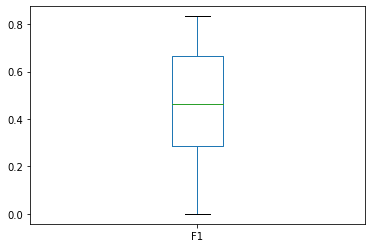

In [62]:
cleaner['F1'].plot.box()

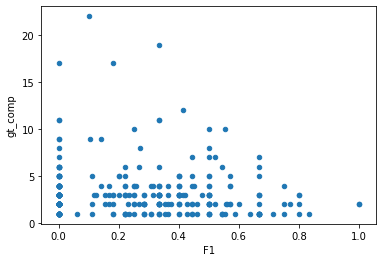

In [63]:
result.plot.scatter('F1','gt_comp')

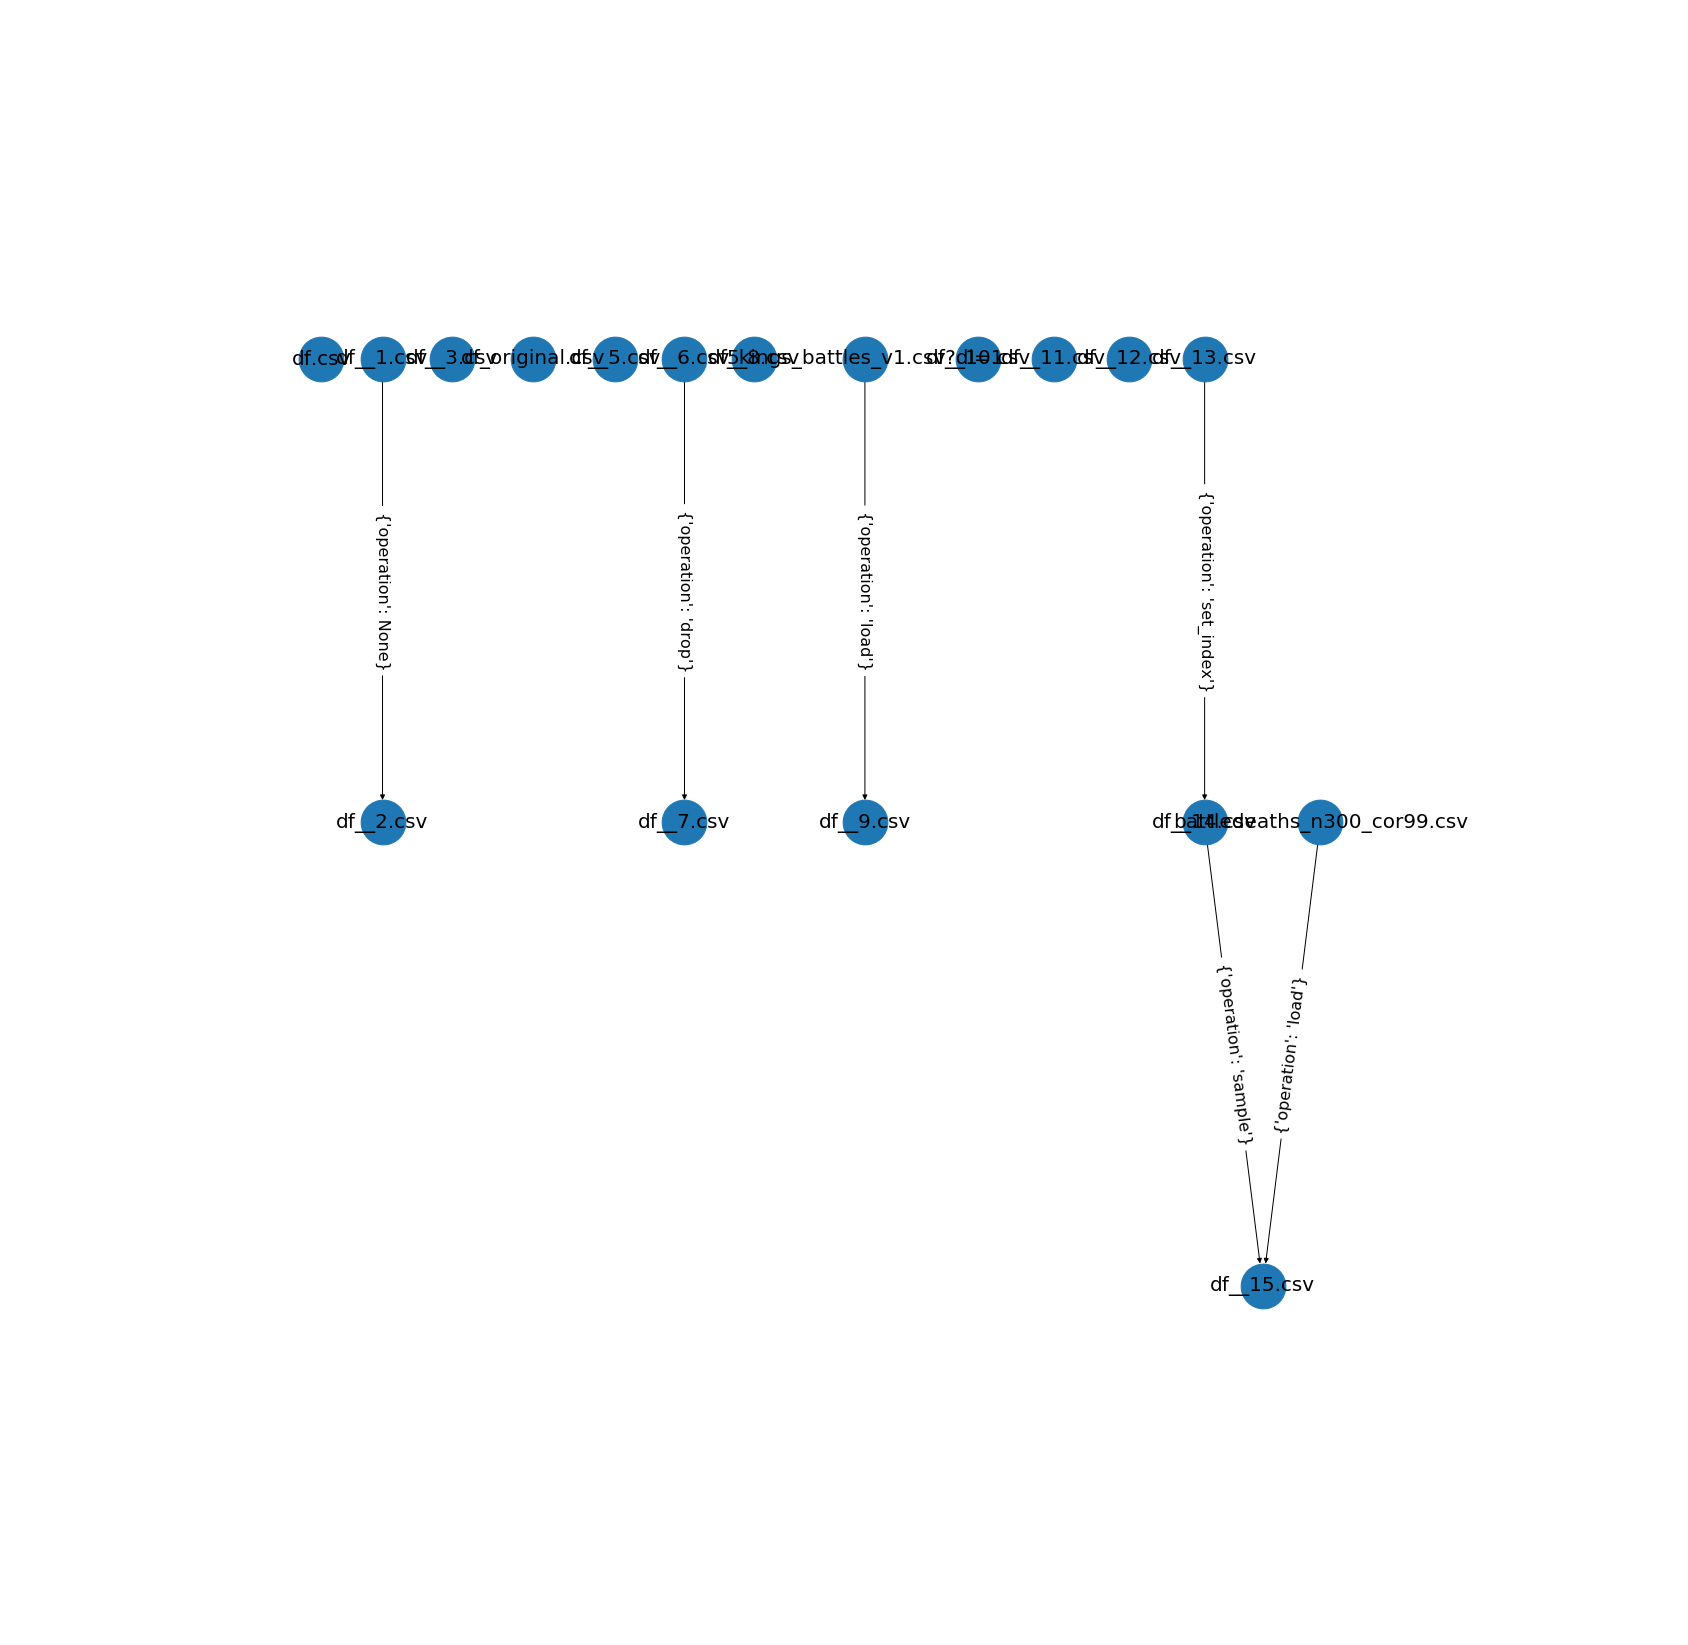

<module 'matplotlib.pyplot' from '/home/suhail/anaconda3/envs/relic/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [64]:
g = graphs.get_graph(RESULT_DIR,'nb_1026631.ipynb')
graphs.draw_graph(g, canvas_size=(30,30))

In [101]:
import networkx as nx
nx.drawing.nx_pydot.write_dot(g, 'test.dot')

In [42]:
get_notebook_artifact_list('nb_1195712.ipynb')

['/home/suhail/ok/nb_1195712.ipynb/artifacts/df.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/test.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/titanic.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/train.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/submission.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/X_train.csv',
 '/home/suhail/ok/nb_1195712.ipynb/artifacts/X_test.csv']

In [122]:
errors

['nb_1026631.ipynb',
 'nb_665007.ipynb',
 'nb_165281.ipynb',
 'nb_212182.ipynb',
 'nb_158183.ipynb',
 'nb_23353.ipynb',
 'nb_422665.ipynb',
 'nb_1099234.ipynb',
 'nb_739891.ipynb',
 'nb_266913.ipynb',
 'nb_201646.ipynb',
 'nb_661088.ipynb']

In [26]:
import json
import os

def find_downloaded_csvs():
    result = pd.DataFrame()
    for nb in notebooks:
        metadata_file = RESULT_DIR+nb+'/run_metadata.json'
        with open(metadata_file) as json_file:
            data = json.load(json_file)
            for cell in data:
                if 'links' in cell:
                    #print(cell['links'])
                    for filename in cell['links'].keys():
                        full_path = RESULT_DIR+nb+'/artifacts/'+filename
                        if os.path.exists(full_path):
                            #print(cell['links'])
                            try:
                                os.remove(full_path)
                            except IsADirectoryError as e:
                                pass
                        
                        g = graphs.get_graph(RESULT_DIR,nb)
                        
                        if filename in g.nodes():
                            g.remove_node(filename)
                            outfile = RESULT_DIR+nb+'/'+nb+'_gt_fixed.pkl'
                            nx.write_gpickle(g, outfile)
            

In [27]:
find_downloaded_csvs()

In [127]:
sample = result.sample(20)
sample

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
6,0.600000,6.0,7,15,pandas_cell,3.0,1.0,3.0,7.0,2.0,...,NaN,0.0,nb_668735.ipynb,7.0,PC2,0.750000,0.500000,891,1.0,0.270027
3,0.000000,3.0,7,3,pandas_cell,0.0,4.0,3.0,7.0,6.0,...,NaN,0.0,nb_324400.ipynb,6.0,PC2,0.000000,0.000000,275982,0.0,4.214252
3,0.222222,3.0,18,3,pandas_cell,3.0,15.0,6.0,18.0,3.0,...,NaN,0.0,nb_423587.ipynb,9.0,PC2,0.166667,0.333333,7,1.0,1.729499
2,0.400000,2.0,5,5,pandas_cell,1.0,0.0,3.0,5.0,3.0,...,NaN,0.0,nb_292141.ipynb,3.0,PC2,1.000000,0.250000,6,1.0,0.169317
4,0.400000,4.0,9,64,pandas_cell,2.0,4.0,2.0,9.0,5.0,...,NaN,0.0,nb_923025.ipynb,7.0,PC2,0.333333,0.500000,357,1.0,1.069518
7,0.235294,7.0,8,17,pandas_cell,2.0,8.0,5.0,8.0,1.0,...,NaN,0.0,nb_1127960.ipynb,8.0,PC2,0.200000,0.285714,4119,0.0,1.258747
1,0.333333,1.0,5,7,pandas_cell,1.0,1.0,3.0,5.0,2.0,...,NaN,0.0,nb_339588.ipynb,2.0,PC2,0.500000,0.250000,80,1.0,0.122177
2,0.000000,2.0,7,5,pandas_cell,0.0,4.0,2.0,7.0,2.0,...,NaN,0.0,nb_391713.ipynb,2.0,PC2,0.000000,0.000000,4622,2.0,0.288837
3,0.571429,3.0,12,15,pandas_cell,4.0,3.0,3.0,12.0,5.0,...,NaN,0.0,nb_747796.ipynb,7.0,PC2,0.571429,0.571429,50,3.0,1.673882
1,0.000000,1.0,5,10,pandas_cell,0.0,2.0,2.0,5.0,2.0,...,NaN,0.0,nb_1201018.ipynb,3.0,PC2,0.000000,0.000000,214,2.0,0.094446


In [129]:
sample.nb_name.to_csv('20200218_sample.csv')

/home/suhail/anaconda3/envs/relic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [133]:
#sample.to_csv('20200218_sample_scores.csv')

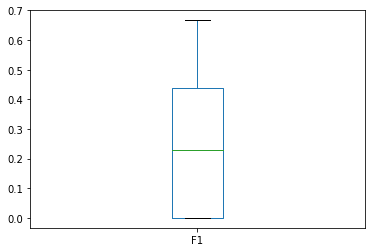

In [134]:
sample['F1'].plot.box()

In [135]:
result.F1.mean()

0.26060177180370847

In [139]:
sample[sample.nb_name== 'nb_75676.ipynb']

,F1,Unnamed: 0,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,files,gt_comp,...,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,symdiff,time
6,0.166667,6.0,13,4,pandas_cell,2.0,10.0,10.0,12.0,4.0,...,NaN,1.0,nb_75676.ipynb,7.0,PC2,0.166667,0.166667,3,4.0,2.091926


In [106]:
sample = pd.read_csv('20200218_sample_scores.csv')
sample_baselines = result[result.nb_name.isin(sample.nb_name)]

In [357]:
nb_list = sample_baselines.nb_name.unique()
nb_list

array(['nb_1048957.ipynb', 'nb_292141.ipynb', 'nb_180346.ipynb',
       'nb_213583.ipynb', 'nb_391713.ipynb', 'nb_339588.ipynb',
       'nb_1183746.ipynb', 'nb_668735.ipynb', 'nb_458180.ipynb',
       'nb_1127960.ipynb'], dtype=object)

In [202]:
new_results.loc[new_results.nb_name == 'nb_814615.ipynb']

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,...,recall,F1,missing_files,time,pre_cluster,files,symdiff,gt_comp,isdag,pathlen
0,nb_814615.ipynb,10886,11,5,False,5,cell,2,3,2,...,0.5,0.444444,0,0.059111,No Precluster,5,0,1,True,3.0
0,nb_814615.ipynb,10886,11,5,False,5,col,2,3,2,...,0.5,0.444444,0,0.052288,No Precluster,5,0,1,True,3.0
4,nb_814615.ipynb,10886,11,5,False,5,pc2cellcol,2,3,2,...,0.5,0.444444,0,0.079596,PC2,5,0,1,True,3.0
4,nb_814615.ipynb,10886,11,5,False,5,pc2colcell,2,3,2,...,0.5,0.444444,0,0.078360,PC2,5,0,1,True,3.0


In [205]:
[print('/home/suhail/ok/'+nb) for nb in nb_list]

/home/suhail/ok/nb_28174.ipynb
/home/suhail/ok/nb_417011.ipynb
/home/suhail/ok/nb_292141.ipynb
/home/suhail/ok/nb_1172641.ipynb
/home/suhail/ok/nb_315237.ipynb
/home/suhail/ok/nb_814615.ipynb
/home/suhail/ok/nb_442286.ipynb
/home/suhail/ok/nb_422202.ipynb
/home/suhail/ok/nb_339588.ipynb
/home/suhail/ok/nb_264704.ipynb
/home/suhail/ok/nb_120345.ipynb
/home/suhail/ok/nb_458180.ipynb
/home/suhail/ok/nb_495072.ipynb


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [25]:
result = experiment2_results()
result

,F1,artifacts,cell_threshold,col_threshold,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,time
7,0.709677,16,0.00,0.00,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.560998
7,0.709677,16,0.00,0.05,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.423102
7,0.709677,16,0.00,0.10,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.388725
7,0.709677,16,0.00,0.15,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.403132
7,0.709677,16,0.00,0.20,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.384403
7,0.709677,16,0.00,0.25,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.379670
7,0.709677,16,0.00,0.30,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.375693
7,0.709677,16,0.00,0.35,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.398078
7,0.709677,16,0.00,0.40,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.383192
7,0.709677,16,0.00,0.45,5,pc2cellcol,11.0,5.0,4.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.687500,0.733333,446169,1.387516


In [26]:
idx = result.groupby('nb_name', sort=False)['F1'].transform(max) == result['F1']
top_vals = result[idx]
top_vals

,F1,artifacts,cell_threshold,col_threshold,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,time
7,0.903226,16,0.10,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.373830
7,0.903226,16,0.10,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.382558
7,0.903226,16,0.10,0.10,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.396590
7,0.903226,16,0.10,0.15,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.393304
7,0.903226,16,0.15,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.400992
7,0.903226,16,0.15,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.428608
7,0.903226,16,0.15,0.10,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.409196
7,0.903226,16,0.15,0.15,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.401361
7,0.903226,16,0.20,0.00,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.393811
7,0.903226,16,0.20,0.05,5,pc2cellcol,14.0,2.0,1.0,0.0,NaN,0.0,london-crime,8.0,PC2,0.875000,0.933333,446169,1.374753


In [27]:
idx2 = top_vals.groupby('nb_name', sort=False)['cell_threshold'].transform(max) == top_vals['cell_threshold']
top_vals2 = top_vals[idx2]

In [28]:
idx3 = top_vals2.groupby('nb_name', sort=False)['col_threshold'].transform(max) == top_vals2['col_threshold']
top_vals3 = top_vals2[idx3]

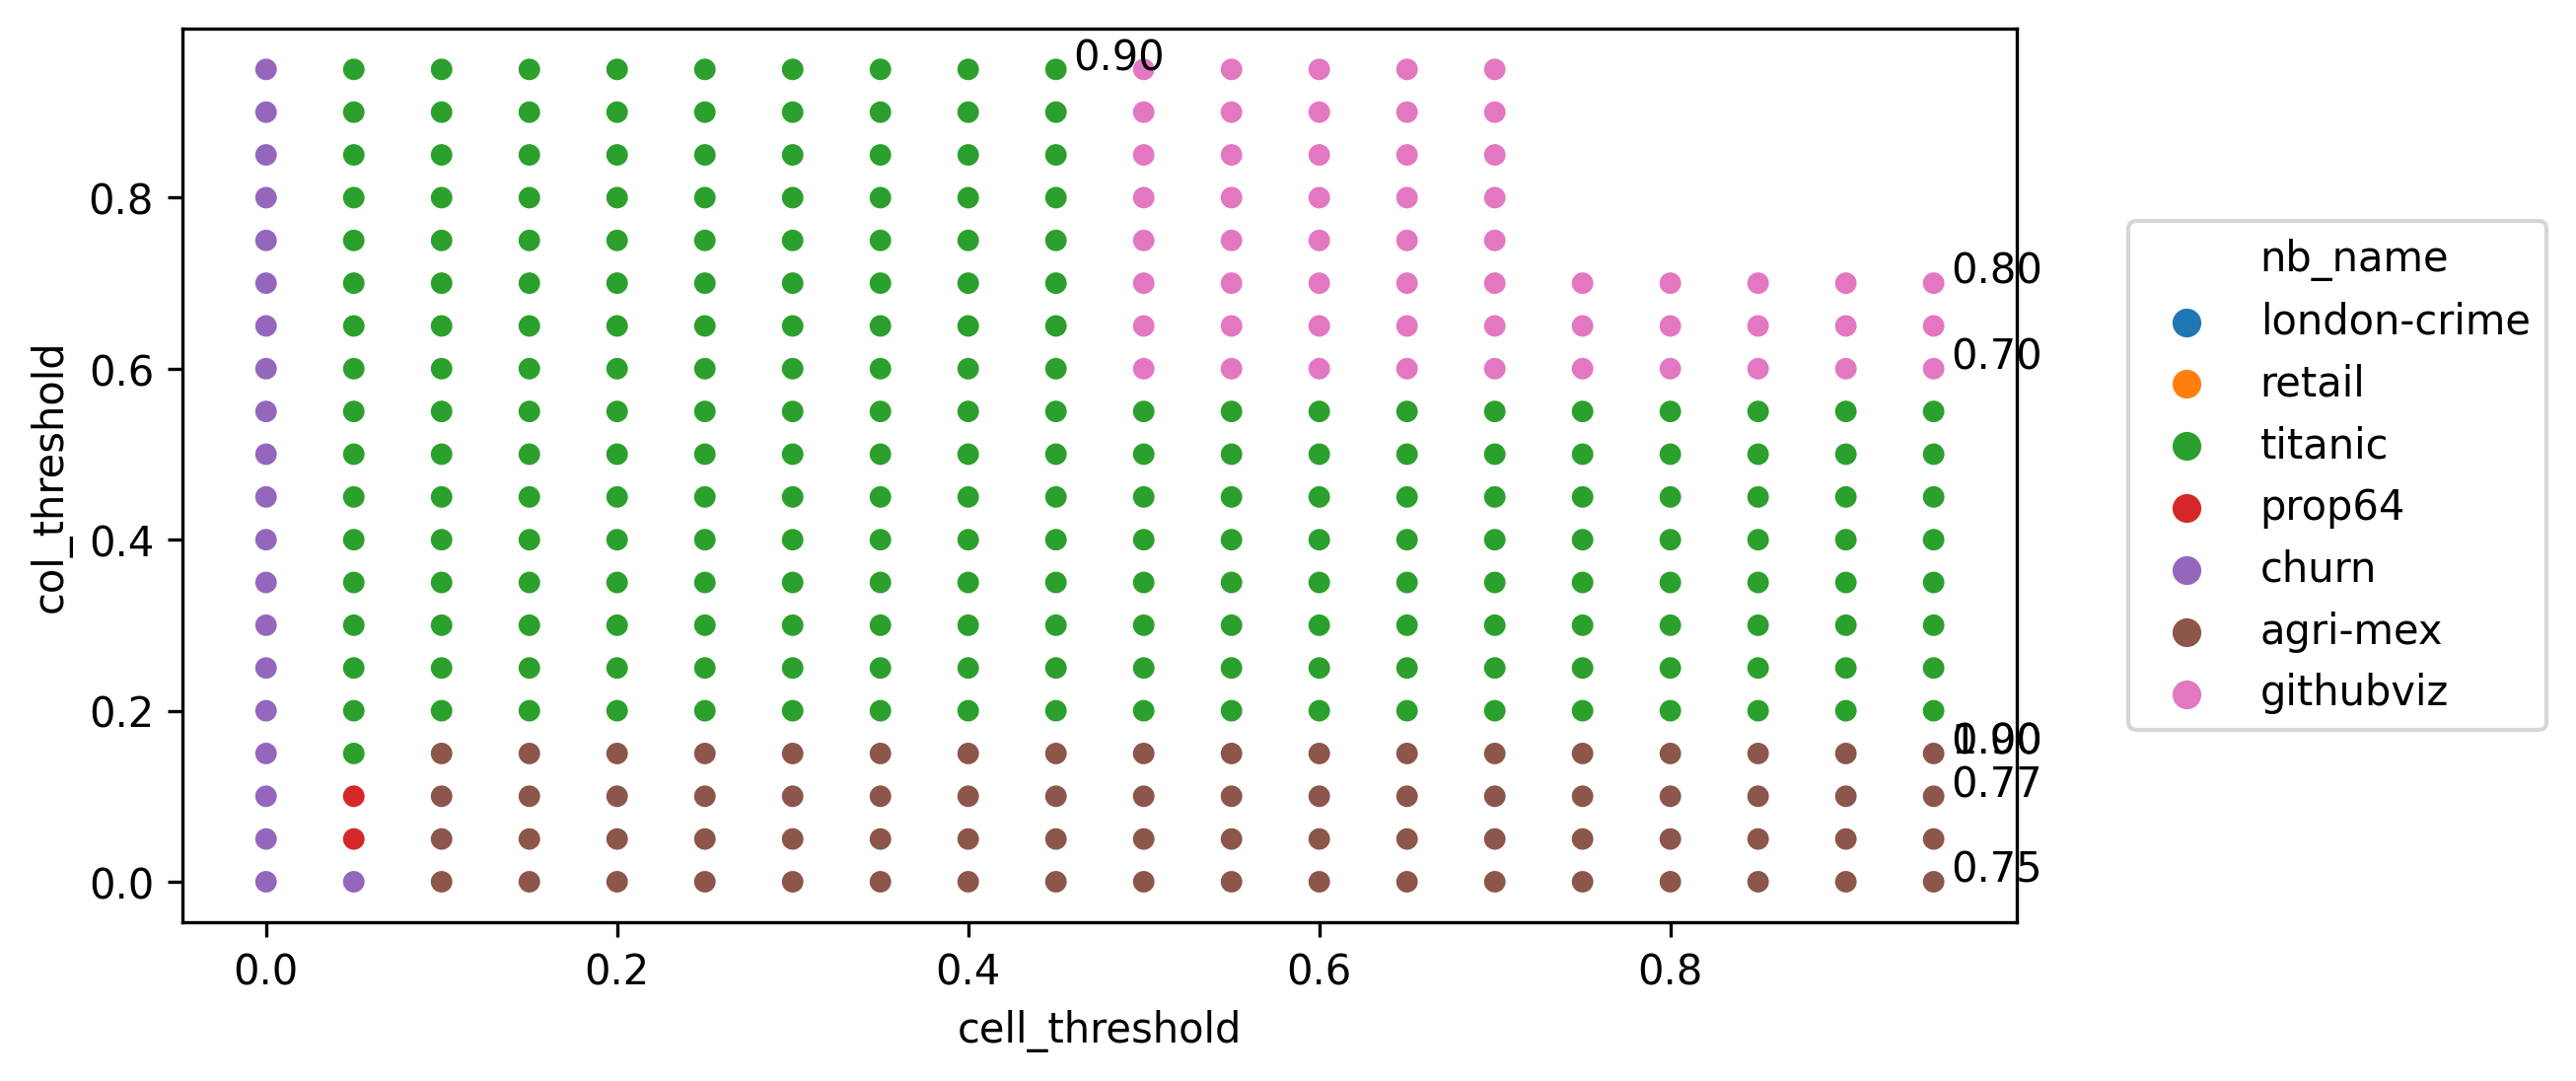

In [29]:
# library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')

sns.scatterplot(x='cell_threshold', y='col_threshold', data=top_vals, hue='nb_name')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], '{:.2f}'.format(point['val']))
        
    
label_point(top_vals3.cell_threshold, top_vals3.col_threshold, top_vals3.F1, plt.gca())  


plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)


interactive(children=(Dropdown(description='notebook', options=('london-crime', 'retail', 'titanic', 'prop64',…

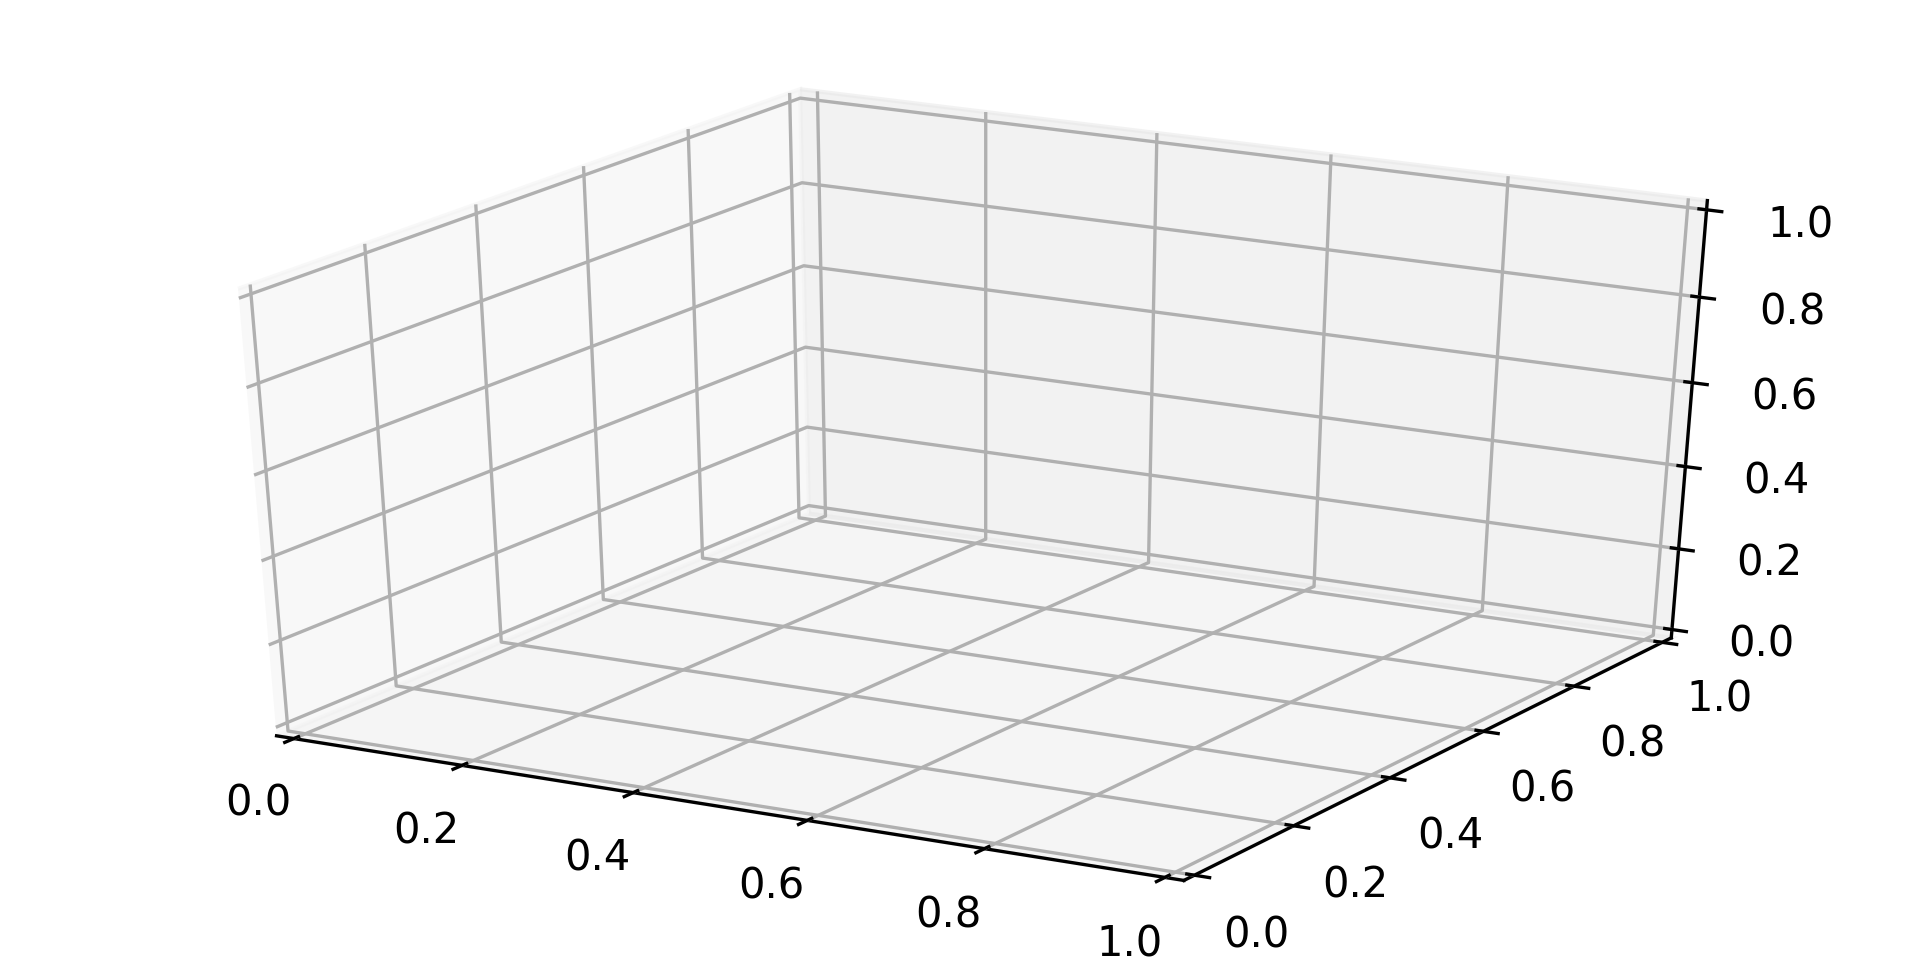

In [103]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets

def select_notebook(notebook=notebooks):
    #print(notebook)
    df=result.loc[result.nb_name == notebook]
    fig = plot_3d(df,notebook)


def plot_3d(df, notebook):
    fig = plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(df['col_threshold'], df['cell_threshold'], df['F1'], cmap=plt.cm.viridis, linewidth=0.2)
    fig.colorbar( surf, shrink=0.5, aspect=5)
    ax.set_ylabel('col threshold')
    ax.set_xlabel('cell threshold')
    ax.set_zlabel('F1')
    plt.title('Threshold Curve for '+notebook)
    
    
    
    return fig

    
im = ipywidgets.interact_manual(select_notebook, notebook=notebooks)


In [60]:
import matplotlib.pyplot as plt

# New Counting Metric for Ground Truth

In [12]:
def equiv_edges(sim_dict):
    all_equiv_edges = []
    for key, value in sim_dict.items():
        equivalent_edges = [frozenset([str(key[0])+'.csv', str(key[1])+'.csv'])]
        for v in value:
            equivalent_edges.append(frozenset([str(key[0])+'.csv', str(v)+'.csv']))
        all_equiv_edges.append(equivalent_edges)
    return all_equiv_edges

def get_edge_frozensets(graph):
    edge_list = []
    for e in graph.edges():
        edge_list.append(frozenset(e))
    return edge_list
        
def find_edge_group_index(edge, equiv_edge_list):
    for i, group in enumerate(equiv_edge_list):
        if edge in group:
            #print('Equiv Edge Group Found!')
            return i
    return None

def find_gt_edge_from_equiv_group(equiv_edge_list, groupid, gt_edge_list):
    for edge in equiv_edge_list[groupid]:
        if edge in gt_edge_list:
            return edge
    return None

def compute_PR_equiv(gt_edge_list, inferred_edge_list, equiv_edge_list):
    remaining_gt_edges = gt_edge_list
    correct_edges = []
    incorrect_edges = []
    
    for e in inferred_edge_list:
        #First Check if Edge is in GT
        found = False
        if e in remaining_gt_edges:
            correct_edges.append(e)
            remaining_gt_edges.remove(e)
            to_remove_from_equiv = find_edge_group_index(e, equiv_edge_list)
            if to_remove_from_equiv:
                equiv_edge_list.pop(to_remove_from_equiv)
            found = True
        else:
            equiv_edge_group = find_edge_group_index(e, equiv_edge_list)
            if equiv_edge_group:
                print('Edge found in equiv edge group')
                correct_edges.append(e)
                remaining_gt_edges.remove(find_gt_edge_from_equiv_group(equiv_edge_list, equiv_edge_group, gt_edge_list))
                equiv_edge_list.pop(equiv_edge_group)
                found = True 
        
        if not found:
            incorrect_edges.append(e)
            
    #print(equiv_edge_list)
    
    return correct_edges, incorrect_edges, remaining_gt_edges


    
def compute_new_PR_from_result(RESULT_DIR, nb, metric):
    with open(RESULT_DIR+'/'+nb+'/'+nb+'_gt_similar_nodes.pkl', 'rb') as handle:
        sim_dict = pickle.load(handle)
        

    print(metric)
    equiv_edge_list = equiv_edges(sim_dict)
    num_alt_edge_list = 0
    for group in equiv_edge_list:
        num_alt_edge_list += len(group) -1
    
    #print(equiv_edge_list)
    gt_list = get_edge_frozensets(graphs.get_graph(RESULT_DIR, nb).to_undirected())
    inferred_list =  get_edge_frozensets(graphs.get_graph_edge_list(RESULT_DIR, nb, metric))
    #print (inferred_list)
    total_edges = len(gt_list)
    #print(total_edges)
    correct, to_remove, to_add = compute_PR_equiv(gt_list, inferred_list, equiv_edge_list)
    #print(correct,to_remove,to_add)
    try:
        precision = float(len(correct))/len(inferred_list)
        recall = float(len(correct))/total_edges
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError as e:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    
    return {'nb': nb,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'correct_edges': correct,
            'to_add': to_add,
            'to_remove': to_remove,
            'alt_edges': num_alt_edge_list,
            'total_edges': total_edges
            }



In [247]:
nb_data = []

for nb in notebooks:
    try:
        result_dict = compute_new_PR_from_result(RESULT_DIR, nb, 'pc2cellcol+group+join+pivot')
        print(nb, result_dict['F1'], result_dict['alt_edges'], result_dict['total_edges'])
        nb_data.append(result_dict)
    except (ValueError, FileNotFoundError) as e:
        #print('No result here')
        pass

pc2cellcol+group+join+pivot
20200802-224614 0.8627450980392156 2 26
pc2cellcol+group+join+pivot
20200803-124938 0.8936170212765957 3 24
pc2cellcol+group+join+pivot
20200803-125635 0.8780487804878049 11 62
pc2cellcol+group+join+pivot
20200803-125029 0.8000000000000002 4 25
pc2cellcol+group+join+pivot
20200802-230158 0.9302325581395349 5 65
pc2cellcol+group+join+pivot
20200803-130249 0.8125 10 65
pc2cellcol+group+join+pivot
20200802-224920 0.875 0 24
pc2cellcol+group+join+pivot
20200802-225038 0.9444444444444444 0 72
pc2cellcol+group+join+pivot
20200803-125433 0.782608695652174 2 71
pc2cellcol+group+join+pivot
20200802-224609 0.9130434782608695 1 23
pc2cellcol+group+join+pivot
20200803-130030 0.9022556390977443 1 67
pc2cellcol+group+join+pivot
20200802-225235 0.7424242424242424 9 66
pc2cellcol+group+join+pivot
20200802-224518 0.96 4 25
pc2cellcol+group+join+pivot
20200802-224550 0.6296296296296297 1 27
pc2cellcol+group+join+pivot
20200803-125023 0.8095238095238095 0 21
pc2cellcol+group+j